In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision import transforms, models
from PIL import Image
import numpy as np

In [2]:
transform = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.ToTensor(), 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [3]:
class_names = ['Healthy', 'RoughBark', 'StripeCanker']

In [4]:
class SimCLRModel(nn.Module):
    def __init__(self, base_model, projection_dim=128):
        super(SimCLRModel, self).__init__()
        self.base_model = base_model
        self.base_model = nn.Sequential(*list(self.base_model.children())[:-1])  
        
        self.projection_head = nn.Sequential(
            nn.Linear(512, 512),  
            nn.ReLU(),
            nn.Linear(512, projection_dim)  
        )

        self.classification_head = nn.Linear(512, 3)

    def forward(self, x, mode='contrastive'):
        features = self.base_model(x)  
        features = features.view(features.size(0), -1)  
        
        if mode == 'contrastive':
            projection = self.projection_head(features)  
            return projection
        
        elif mode == 'classification':
            return self.classification_head(features)

In [5]:
def predict_image(image_path, model, device):
    img = Image.open(image_path).convert("RGB") 
    img = transform(img).unsqueeze(0).to(device) 

    model.eval()

    with torch.no_grad():
        output = model(img, mode='classification') 
        _, predicted_class = torch.max(output, 1) 

    predicted_label = class_names[predicted_class.item()]
    
    img = Image.open(image_path)
    plt.imshow(img)
    plt.title(f"Predicted: {predicted_label}")
    plt.axis('off')
    plt.show()

    return predicted_label

In [6]:
resnet = models.resnet18(pretrained=True)
model = SimCLRModel(resnet)

d:\RP025-02\venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\RP025-02\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
model.load_state_dict(torch.load('simclr_model.pth'))

<All keys matched successfully>

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

SimCLRModel(
  (base_model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stat

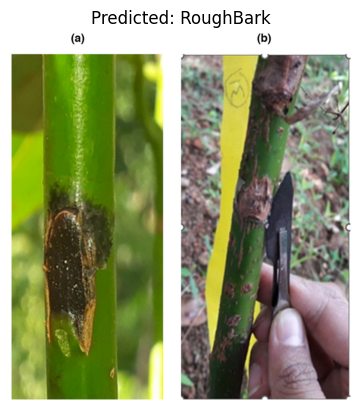

In [39]:
image_path = "testdata\\StripeCanker\\jph13169-fig-0008-m.jpg"
prediction = predict_image(image_path, model, device)